# Detecting marine heatwave events with xmhw

## Introduction

*xmhw* is a xarray based version of the MarineHeatWave code.
The main difference with the original code are the following:
* uses xarray and dask
* the calculation of climatologies and detection of mhw events are in separate functions, so they can be called independently
* can handle multi dimensional grids and detect land points
* NaNs treatment can be customised
* severity of events added to *detect* function output
* produce xarray datasets instead of list of dictionaries

### Import functions from xmhw
Import *threhshold* to calculate the climatologies and *detect* to detect the mhw events.

In [1]:
import xarray as xr
import dask
from xmhw.xmhw import threshold, detect

In [3]:
ds

<xarray.Dataset>
Dimensions:  (lat: 8, lon: 4, time: 731)
Coordinates:
  * lat      (lat) float32 -42.88 -42.62 -42.38 -42.12 ... -41.62 -41.38 -41.12
  * lon      (lon) float32 147.6 147.9 148.1 148.4
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2004-12-31T12:00:00
Data variables:
    sst      (time, lat, lon) float32 nan nan 17.04 17.38 ... nan nan nan 15.83

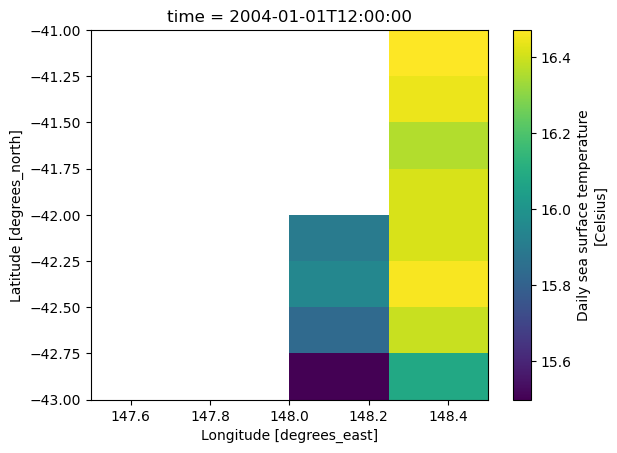

In [32]:
ds.sst[365,:,:].plot()

### Calculating the climatologies

For this demo I am using a small subset of the NOAA OISST timeseries. You can use whatever seawater temperature dataset you have available, just select a small region initially to test the code.

In [11]:
# open file, read sst and calculate climatologies 
ds =xr.open_dataset('/home/Xinru.Li/Project1/envs/py310/xmhw/test/testdata/oisst_2003_2004.nc')  # this OISST file is from the testdata folder of xmhw package, i.e. located around sourtheastern tasmania 
sst = ds['sst']

# an option to try
sst = sst.fillna(1.e-30)

clim = threshold(sst)
clim

<xarray.Dataset>
Dimensions:   (lat: 8, lon: 4, doy: 366)
Coordinates:
  * lat       (lat) float32 -42.88 -42.62 -42.38 -42.12 ... -41.62 -41.38 -41.12
  * lon       (lon) float32 147.6 147.9 148.1 148.4
    quantile  float64 0.9
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
Data variables:
    thresh    (doy, lat, lon) float64 dask.array<chunksize=(365, 1, 4), meta=np.ndarray>
    seas      (doy, lat, lon) float32 dask.array<chunksize=(365, 1, 4), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2023-10-03: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

As you can see above **clim** is a xarray dataset with two variables:
 * thresh - the percentile threshold
 * seas - the climatology mean.<br>
 
The dimension is **doy** which stands for day of the year, this is based on a 366 days calendar. <br>
Finally the dataset includes a few global attributes detailing the climatology period, the percenttile used and other parameters used in the calculation.<br>
This can be easily saved to a file simply by running:<br>
> clim.to_netcdf('filename')

### Detecting MHW events

Now that we have the climatologies we can run detect

In [12]:
mhw = detect(sst, clim['thresh'], clim['seas'])
mhw

ValueError: cannot set a frame with no defined index and a scalar

We can see above all the output variables listed and again global attributes detailing the dataset settings.<br>
The dimension **events** represents the starting point of each event. Let's select one grid point to see more in detail its structure.

In [4]:
mhw_point = mhw.isel(lat=6, lon=1)
mhw_point.events

<xarray.DataArray 'events' (events: 41)>
array([  1.,  11.,  12.,  24.,  32.,  38.,  51.,  52.,  73.,  75.,  76.,  96.,
        97.,  99., 112., 113., 114., 115., 138., 141., 143., 144., 145., 171.,
       172., 173., 180., 202., 206., 208., 209., 224., 225., 613., 614., 645.,
       647., 648., 677., 697., 709.])
Coordinates:
    lat      float64 -41.38
    lon      float64 148.4
  * events   (events) float64 1.0 11.0 12.0 24.0 ... 648.0 677.0 697.0 709.0

Printing out the all events array shows that the first detected event occurs at the 91st timestep of the original timeseries, the last events starts at timestep 14381.<br>
Not all these events will be occuring at the selected grid point. We can see that having a look at the index_start or time_start variables.<br>
By dropping all the NaN values along the events dimension, we can see there are 60 mhw events occuring at this grid point.

In [5]:
mhw_point.time_start.dropna(dim='events')

<xarray.DataArray 'time_start' (events: 6)>
array(['2003-01-12T12:00:00.000000000', '2003-02-22T12:00:00.000000000',
       '2003-04-23T12:00:00.000000000', '2003-05-22T12:00:00.000000000',
       '2003-07-22T12:00:00.000000000', '2004-11-28T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lat      float64 -41.38
    lon      float64 148.4
  * events   (events) float64 11.0 52.0 112.0 141.0 202.0 697.0

As for the climatologies dataset, we can save the mhw dataset to a netcdf file easily.

In [6]:
mhw.to_netcdf('mhw_test.nc')

This file has a small grid, so we could save it as it is and still produce a small file. However, it is worth adding some "encoding" to save storage, this will be necessary when dealing with bigger grids.<br>
Xarray has automatically used a float64 format for ~20 of the variables. Converting all the variables to float32 format will save a lot of storage.<br>
This dataset also has a lot of NaNs values, as its structure is "sparse", so it is a good idea to save the results in a compressed format.<br>
Encoding allows us to add internal compression and also to convert the arrays format.<br>

In [9]:
# First we create a dictionary representing the settings we want to use
# then we apply that to all the dataset variables and we use the resultingi
# dictionary when calling to_netcdf() 
#
comp = dict(zlib=True, complevel=5, shuffle=True, dtype='float32')
encoding = {var: comp for var in mhw.data_vars}
mhw.to_netcdf('mhw_test_encoded.nc', encoding=encoding)

Checking the sizes of both files

In [8]:
!du -sh mhw_test.nc
!du -sh mhw_test_encoded.nc

109M	mhw_test.nc
2.2M	mhw_test_encoded.nc


## Threshold in detail
In the previous example the threshold function was called with its default arguments, so only temperature was needed.<br>
As for the original Marine heatwave code several other parameters can be set:
````
 threshold(temp, tdim='time', climatologyPeriod=[None,None], pctile=90, windowHalfWidth=5,  
           smoothPercentile=True, smoothPercentileWidth=31, maxPadLength=None, 
           coldSpells=False, Ly=False, anynans=False, skipna=False):
````

Where *temp* is the temperature timeseries, this is the only input needed. Arguments names are the same as the original MarineHeatWave code, where possible:<br>
   
 * **climatologyPeriod**: list(int), optional
       Period over which climatology is calculated, specified as list
       of start and end years. Default is to use the full time series.
 * **pctile**: int, optional 
       Threshold percentile used to detect events (default=90)
 * **windowHalfWidth**: int, optional
       Half width of window about day-of-year used for the pooling of
       values and calculation of threshold percentile (default=5)
 * **smoothPercentile**: bool, optional 
       If True smooth the threshold percentile timeseries with a
       moving average (default is True)
 * **smoothPercentileWidth**: int, optional
       Width of moving average window for smoothing threshold in days,
       has to be odd number (default=31)
 * **maxPadLength**: int, optional
        Specifies the maximum length (days) over which to interpolate
        NaNs in input temp time series. i.e., any consecutive blocks of
        NaNs with length greater than maxPadLength will be left as
        NaN. If None it does not interpolate (default is None).
 * **coldSpells**: bool, optional
       If True the code detects cold events instead of heat events
       (default is False)
 * **Ly**: bool, optional  !! Not yet fully implemented
        If True the length of the year is < 365/366 days (e.g. a 360 day
        year from a climate model). This affects the calculation
        of the climatology (default is False)


 

#### New arguments
 * **tdim** - optional, to specify the time dimension name, default is "time" . NB you do not need to pass the time array as in the original as the timeseries is an xarray data array the time dimension is included <br>
 * **anynans**: bool, optional
       Defines in land_check which cells will be dropped, if False
        only ones with all NaNs values, if True all cells with even
        1 NaN along time dimension will be dropped (default is False)
 * **skipna**: bool, optional 
        If True percentile and mean function will use skipna=True.
        Using skipna option is much slower (default is False)<br>

More on missing values later.

#### Example
This is just showing how we can call the function changing some of the default parameters. <br>
In this case we are assuming sst time dimension is called 'time_0' and we want a base period from 1 Jan 1984 to 31 Dec 1994.

> clim = threshold(sst, climatologyPeriod=[1984,1994], tdim='time_0')

NB after passing the timeseries as first argument, the order of the other
   ones is irrelevant as they are all keywords arguments.

It is important to notice that differently from the original function which takes a numpy 1D array, because we are using xarray we can pass a 3D array (in fact we could pass any n-dim array) and the code will deal with it.<br>
We selected a 12X20 lat-lon region and of these 135 grid cells are ocean. <br>

The function return a dataset with the arrays: <br>
   - **thresh** - for the threshold timeseries
   - **seas** - for the seasonal mean <br>

Differently from the original function, here the climatologies are saved not along the entire timeseries but only along the new **doy** dimension. Given that xarray keeps the coordinates with the arrays there is no need to repeat the climatologies along the time axis.<br>
We also try to follow the CF conventions and define appropriate variables attributes and some global attributes that record the parameters used to calculate the threshold for provenance.

### Handling of dimensions and land points

As so before we are passing the full grid to the function without worrying about land points, or how many dimensions it has. Before calculating anything, the code calls the function land_check() (from xmhw.identify). This function handles the dimensions and land points of the grid in two steps:<br>
  - stacks all dimensions but the time dimension in a new 'cell' dimension;
  - removes all the land points, these are assumed to have all NaN values along the time axis

In our example 'cell' will be composed by stacked (lat,lon) points. The resulting array will have (time, cell) dimensions, and the cell points which are land will not be part of it. The climatologies then will be calculated for each cell point. Finally the results will be unstacked before returning the final output.<br>
NB This approach can occasionally produce a grid of different size from the original if all the cells at a specific latitude or longitude are masked as land. In that case the final grid will be smaller, you can however easily reindex your results as the original grid.
> clim = clim.reindex_like(sst)

#### Single-point timeseries

If working with a single-point timeseries, there is no need to check for land points or parallelise the workflow, hence from version 0.9.2 the code will check for the number of dimensions and when this is equal to one, it assumes it is the time dimension and skip all grid operations, including land_check.

### Handling of NaNs

It is important to understand how the **threshold()** function is dealing with NaNs.<br>
If there are NaNs values in the timeseries that is passed to the function, this could produce wrong results.
You can take care of NaNs in the timeseries before passing it to threshold or you can take one of the following approaches:
1) We already saw that land_check() will remove all the points that have all NaNs values along the time dimension.<br> You can choose to be more strict and also exclude any ell points that even just one NaN value.
To do so you can set the **anynans** argument to True.<br> This is a bit of an extreme approach as especially with observations data it is not unusual to have a few NaNs.<br>
> clim = threshold(sst, anynans=True)

2) set **skipna** to True - this tells the code to skip NaNs when calculating averages and/or the percentile.<br>
By default the **skipna** argument is set to False as using this option can double up the execution time. But if you are working on a small grid than it is a safer option.<br>
> clim = threshold(sst, skipnans=True)

3) use **maxPadLength** this will trigger interpolation for all NaNs points, with the exception of consecutive blocks with length greater than maxPadLength. 
> clim = threshold(sst, maxpadlength=5, anynans=True)

Used in conjuction with **anynans** as shown above you can use it to eleiminate only the cell points that have bigger gaps.

## Detect function in detail
The *detect* function identifies all the mhw events and their characteristics. It corresponds to the second part of the original detect function and again mimic the logic and most of options of the original code.

````
    def detect(temp, th, se, tdim='time', minDuration=5, joinGaps=True, 
               maxGap=2, maxPadLength=None, coldSpells=False,
               intermediate=False, anynans=False):

````
Apart from the timeseries, the threshold and the seasonal average, the other arguments are all optional.<br>
As for threshold an option to pass the name of the time dimension (**tdim**) and the **anynans** argument to define which grid cells will be removed from calculation, were added.<br> It is important to used this last consistently with the approach used when calculating the threshold.<br><br>
The last new argument is **intermediate**, when set to True, also intermediate results are saved. These include the original timeseries, climatologies, detected events, categories and some of the mhw properties but along the full length of the time axis.<br>

Arguments specific to **detect()**:
 * minDuration: int, optional
     Minimum duration (days) to accept detected MHWs (default=5)
 * joinGaps: bool, optional
     If True join MHWs separated by a short gap (default is True)
 * maxGap: int, optional
     Maximum limit of gap length (days) between events (default=2)

In [6]:
mhw, intermediate = detect(sst, clim['thresh'], clim['seas'], intermediate=True)
intermediate

<xarray.Dataset>
Dimensions:            (lat: 8, lon: 2, time: 731)
Coordinates:
  * lat                (lat) float32 -42.88 -42.62 -42.38 ... -41.38 -41.12
  * lon                (lon) float32 148.1 148.4
  * time               (time) datetime64[ns] 2003-01-01T12:00:00 ... 2004-12-...
Data variables: (12/15)
    ts                 (time, lat, lon) float32 17.04 17.38 16.99 ... nan 15.83
    seas               (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    thresh             (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    bthresh            (time, lat, lon) object True True True ... nan False
    events             (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    relSeas            (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    cats               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    duration_moderate  (time, lat, lon) object False False False ... nan False
    duration_strong    (time, lat, lon) object False False False ... nan False
    duration_severe    (time, lat, lon) object False False False ... nan False
    duration_extreme   (time, lat, lon) object False False False ... nan False
    mabs               (time, lat, lon) float32 nan nan nan nan ... nan nan nan

### Block average
The blockAverage function on the original MHW code is used to calculate statistics along a block of time. The default is 1 year block. If the timeseries used starts or ends in the middle of the year then the results for this two years have to be treated carefully.<br><br>
Most of the statistics calculated on the block are simple statistics. Given that the mhw properties are saved now as an array it is simple to calculate them after grouping by year or "bins"of years on the entire dataset.<br>
However, we added xmhw has a block_average() function to reproduce the same results.<br>


In [7]:
# To call with standard parameters, all is needed is the output of detect function 
# I am also passing the intermediate results datasets as a way to provide the temperature and
# climatologies
from xmhw.stats import block_average
block = block_average(mhw, dstime=intermediate)
block

Assuming time is time dimension


ValueError: Input array must be 1 dimensional

#### Block_average function in detail

````
def block_average(mhw, dstime=None, period=None, blockLength=1, mtime='time_start',
                  removeMissing=False, split=False):

    Parameters
    ----------
    mhw: xarray Dataset 
        Includes MHW properties by events
    dstime: xarray DataArray/Dataset, optional
         Based on intermediate dataset returned by detect(), includes
         original ts and climatologies (optional) along 'time' dimension
         (default is None)
         If present and is array or dataset with only 1 variable script assumes this
         is sst and sw_temp is set to True
         If present and dataset with 'thresh' and 'seas' also sw_cats is set to True
    period: pandas Series
        Absolute value of temperature along time index
    blockLength: int, optional
        Size of blocks in years (default=1)
    mtime: str, optional
        Name of mhw time variable to use to assign events to blocks, 
        Options are start or peak times (default='time_start')
    removeMissing: bool, optional
        If True remove statistics for any blocks that has NaNs in ts.
        Work in progress
        (default is False)
    split: bool, optional
        Work in progress
        (default is False)
````

We are still working on the mhw_rank() function to calculate rank and return periods.

### Setting up dask
Both the threshold and detect functions are set up to use dask delayed automatically. I found this was a good away to make sure the main processes would be automatically run in parallel even if you are not experienced with dask. <br>
This approach add some overhead before the actual calculation starts, when dask is working out the task graph. This is usually negligible, but with a bigger grid size you might end up with too many tasks and a less efficinet graph.<br>
In that case, and anytime you are working with limited resources, it is more efficient to split the grid and run the code separately for each grid section. You can easily recompose the original grid by concatenating together the resulting datasets.<br><br>
Even when running the functions on the full grid it is important to setup proper chunks.<br>
The code will make sure that the timeseries for each grid point are all in the same chunk. This is important as it is requires by some of the calculation, it also makes sense as every operation is done cell by cell.<br><br>
>  sst = sst.chunk({'time': -1})

This corresponds to have a chunk size (for time dimension) equal to the length of the timeseries.<br>
The code will not do anything for the other dimensions, so it is a good idea to make sure that once you have chunked the time dimension, you are left with resonable chunk sizes.<br>

In [13]:
# This will tell dask to automatically determine a good chunk size for the other dimensions
# Assuming that the sst variable has (time, lat, lon) dimensions
sst = sst.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})
sst.data

dask.array<xarray-<this-array>, shape=(731, 8, 4), dtype=float32, chunksize=(731, 8, 4), chunktype=numpy.ndarray>

> sst.data 

shows the chunks shape and their size.
As the sst array is quite small we have only 1 chunk in this case, if this was a big grid we would want chunks around 200 MB of size.<br><br>
Below is an example running detect on a big grid by splitting the grid according to chunks.<br>
You can split the grid in different ways and advantage of this methid is that the data will be all in one chunk.<br>
So by managing the chunksize you can optimise the amount of memory used.<br> Whichever way you are splitting the grid make sure that is somehow aligned with the dataset chunks.

In [17]:
# retrieve chunks information
# xt/xy will be lists the number of lat/lon points for each chunk
# As an example
# [20, 20, 20], [30, 30, 30] 
# means we have 20 lat and 30 lon points for each chunk for a total of 600 grid cells
# we set these as out "steps"
dummy, xt, yt = sst.chunks
xtstep = xt[0]
ytstep = yt[0]
# the length of the list gives has the number of chunks, in the example 3
xtblocks = len(xt)
ytblocks = len(yt)
print(xtstep, ytstep, xtblocks, ytblocks)

8 4 1 1


In [19]:
sst

<xarray.DataArray 'sst' (time: 731, lat: 8, lon: 4)>
dask.array<xarray-<this-array>, shape=(731, 8, 4), dtype=float32, chunksize=(731, 8, 4), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -42.88 -42.62 -42.38 -42.12 ... -41.62 -41.38 -41.12
  * lon      (lon) float32 147.6 147.9 148.1 148.4
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2004-12-31T12:00:00
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius

In [8]:
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel
xtstep = 4  # as the sample SST is too small I manually subset it into smaller pieces for testing the following loops with each has more than 1 iteration
ytstep = 1
xtblocks = 2
ytblocks = 2

results = []
for i in range(xtblocks):
    xt_from = i*xtstep
    xt_to = (i+1)*xtstep
    for j in range (ytblocks):
        yt_from = j*ytstep
        yt_to = (j+1)*ytstep
        ts = sst.isel(lat=slice(xt_from,xt_to),lon=slice(yt_from,yt_to))
        clim = threshold(ts)
        th = clim['thresh']
        se = clim['seas']
        j+=1
        # run function
        results.append(detect(ts, th, se, intermediate=True))
        del clim, ts, th, se 
    i+=1

XmhwException: All points of grid are either land or NaN

In [9]:
ts   # I think the threshold function should skip any land points but it seemed incurring complete quit of the calculation

<xarray.DataArray 'sst' (time: 731, lat: 4, lon: 1)>
array([[[nan],
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        [nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -42.88 -42.62 -42.38 -42.12
  * lon      (lon) float32 147.6
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2004-12-31T12:00:00
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius

In [34]:
# Combine the results into one dataset
mhw = xr.merge(results)
mhw

## Detecting heatwaves at different frequencies

The original marine heatwave code assumes the timeseries has daily frequency.<br>
In xmhw you can also calculate the climatologies and then detect the heatwaves based on your timeseries original timestep. So if you are passing monthly data you can calculate monthly climatologies, if you pass a timeseries resampled as an average over n-days than n-days will be your climatology base unit.<br>
This feature is temporarily available only on the timestep branch as it is still a work in progress!

In [10]:
# First I am loading again the test data and 
# create a new timeseries by averaging 5-days interval
sst = ds['sst']
sst_5days = sst.coarsen(time=5, boundary="trim").mean() 

In [36]:
# Now we can calculate the threshold and detect mhw again with the new timeseries.
# We are using the 'tstep=True' option to tell the code to use the 5days intervals
# as timestep base
clim_5days = threshold(sst_5days, smoothPercentileWidth=5, tstep=True)

The first attempt produced an exception this is because at the moment the code cannot handle yet incomplete years. This means that every year needs to have the same number of timesteps. <br>
This timeseries starts in Sep 1981 and end in Jan 2021. So we have to select only the years in between.<br> 
We also have to remove all the 29 of Feb so every year has 365 days that can be equally split in 5 days intervals.

In [32]:
sst_yrs = sst.sel(time=slice('1982','2020'))
sst_365 = sst_yrs.sel(time=~((sst_yrs.time.dt.month == 2) & 
                                (sst_yrs.time.dt.day == 29)))
sst_5days = sst_365.coarsen(time=5, boundary="exact").mean()

In [33]:
clim_5days = threshold(sst_5days, smoothPercentileWidth=5, tstep=True)

In [34]:
clim_5days

<xarray.Dataset>
Dimensions:   (doy: 73, lat: 12, lon: 20)
Coordinates:
    quantile  float64 0.9
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 10 ... 64 65 66 67 68 69 70 71 72 73
  * lat       (lat) float64 -43.88 -43.62 -43.38 -43.12 ... -41.62 -41.38 -41.12
  * lon       (lon) float64 144.1 144.4 144.6 144.9 ... 148.1 148.4 148.6 148.9
Data variables:
    thresh    (doy, lat, lon) float64 dask.array<chunksize=(72, 1, 20), meta=np.ndarray>
    seas      (doy, lat, lon) float64 dask.array<chunksize=(72, 1, 20), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2021-11-19: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

As you can see we ended with only 73 "doy" steps, as this day-of-the-year is really a 5 days interval.<br>
Note also that I've changed the smoothPercentileWidth to 5 instead of the default 31. <br> 
All the default for both the threshold and detect functions are based on a daily timesteps so if you use a different frequency they need to be adapted to produce sensible results.

The detect() function will also need to be passed tstep=True to be consistent.

In [36]:
mhw_5days = detect(sst_5days, clim_5days['thresh'], clim_5days['seas'],
                   maxGap=1, tstep=True)

In [37]:
mhw_5days

<xarray.Dataset>
Dimensions:                         (events: 208, lat: 12, lon: 20)
Coordinates:
  * events                          (events) float64 282.0 284.0 ... 2.818e+03
  * lat                             (lat) float64 -43.88 -43.62 ... -41.12
  * lon                             (lon) float64 144.1 144.4 ... 148.6 148.9
Data variables: (12/31)
    event                           (events, lat, lon) float64 nan nan ... nan
    index_start                     (events, lat, lon) float64 nan nan ... nan
    index_end                       (events, lat, lon) float64 nan nan ... nan
    time_start                      (events, lat, lon) datetime64[ns] NaT ......
    time_end                        (events, lat, lon) datetime64[ns] NaT ......
    time_peak                       (events, lat, lon) datetime64[ns] NaT ......
    ...                              ...
    intensity_var_relThresh         (events, lat, lon) float64 nan nan ... nan
    intensity_var_abs               (events, lat, lon) float32 nan nan ... nan
    category                        (events, lat, lon) float64 nan nan ... nan
    duration                        (events, lat, lon) float64 nan nan ... nan
    rate_onset                      (events, lat, lon) float64 nan nan ... nan
    rate_decline                    (events, lat, lon) float64 nan nan ... nan
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2021-11-19: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration; events ...

You can also use the same option with monthly, weekly data or any other interval which is not daily. This is the option to use also with a 360 days year calendar, as the standard behaviour would be to try to get force the timeseries in a 366 days year, which would cause an error. So even if 'tstep' is False, the code will try to work out the calendar and if this is a 360 days one it will impose tstep=True.